In [2]:
import pandas as pd

#### Let's make use of a decision tree to determine whether to buy an American Option. There's going to be a lot of compounding variables in this. 

In [3]:
BrentDaily = pd.read_csv('BrentDaily.csv')
display (BrentDaily.head())

,date,value
0,2010-04-22,84.58
1,2010-04-23,86.09
2,2010-04-26,86.72
3,2010-04-27,85.59
4,2010-04-28,84.59


In [4]:
from pandas import Series, DataFrame
import numpy as np
import pandas as pd
from patsy import dmatrices
import warnings
%pylab inline
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [5]:
dailyBrent = pd.read_csv('./BrentDaily.csv')
dailyBrent['BrentClose']= dailyBrent[' value']
ShellShares = pd.read_csv('RDS-A.csv')
ShellShares['ShellClose'] = ShellShares['Adj Close']
Comparisson = dailyBrent.set_index('date').join(ShellShares[['ShellClose','Date']].set_index('Date')).dropna()[['BrentClose','ShellClose']]
display (Comparisson.tail())
print (Comparisson.columns.tolist())

,BrentClose,ShellClose
date,,
2020-04-06,22.58,37.330002
2020-04-07,22.10,37.259998
2020-04-08,25.22,38.070000
2020-04-09,20.23,37.910000
2020-04-13,20.23,37.369999


['BrentClose', 'ShellClose']


Correlation:  0.8939762161190508


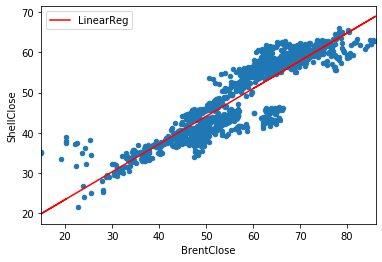

In [6]:
Comparisson = Comparisson.dropna()
Regression = np.polyfit(Comparisson['BrentClose'],Comparisson['ShellClose'], 1)
grid = plt.subplot(1,1,1)
Comparisson['LinearReg'] = np.polyval(Regression,Comparisson['BrentClose'])
Comparisson.plot(x='BrentClose',y='ShellClose', kind='scatter', ax=grid)
Comparisson.plot(x='BrentClose',y='LinearReg', kind='line', ax=grid, color = 'red')
print ("Correlation: ", Comparisson['BrentClose'].corr(Comparisson['ShellClose']))

In [7]:
# This makes a lot of sense, since market prices are largely driven by investor fears/expectations. But there's a ton
# of variation in the data when Brent is <$40. Since that's the current environment, let's look at that more closely

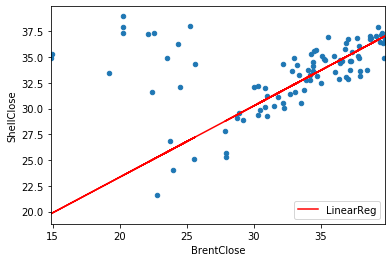

In [10]:
Sub40 = Comparisson[Comparisson['BrentClose']<40]
grid = plt.subplot(1,1,1)
Sub40.plot(x='BrentClose',y='ShellClose', kind='scatter', ax=grid)
Sub40.plot(x='BrentClose',y='LinearReg', kind='line', ax=grid, color = 'red')
plt.show()